# Figure 5: Predict Fos to/from Behavior 

This notebook uses hundreds of end-to-end model fits to predict neural measurents from behavioral and vice-versa. 

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import wandb
import warnings

from fastprogress import progress_bar
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

In [10]:
NUM_BOOTSTRAP = 250
FOS_PARAM_DIR = "../results/bootstrap/fos-strat"
# WAND_FOS_BOOTSTRAP_PROJECT = "linderman-lab/serotonin-fos-seminmf-bootstrap"
WAND_FOS_BOOTSTRAP_PROJECT = "linderman-lab/serotonin-fos-seminmf-bootstrap-strat"
BEHAVIOR_PARAM_DIR = "../results/bootstrap/behavior-strat"
# WAND_BEHAVIOR_BOOTSTRAP_PROJECT = "linderman-lab/serotonin-behavior-bootstrap"
WAND_BEHAVIOR_BOOTSTRAP_PROJECT = "linderman-lab/serotonin-behavior-bootstrap-strat"
FOS_DATA_DIREC = "/Users/scott/Dropbox/Data/serotonin"
NUM_EPOCHS = 12
NUM_POSITIONS = 10
NUM_SYLLABLES = 50
NUM_VOXELS = 348766

## Helpers

In [11]:
# Make a colormap to hide insignificant changes
cmap = cm.RdBu_r
cmap.set_bad('k', alpha=0.25)

def plot_coronal(flat_array, y_idx, alive_voxels, ax=None, **kwargs):
    arr = np.nan * np.zeros(alive_voxels.shape)
    arr[alive_voxels] = flat_array

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    im = ax.imshow(arr[:, y_idx, :].T, **kwargs)
    return ax, im

## Load the data

In [12]:
drugs = np.load(os.path.join(FOS_DATA_DIREC, "drug_ids.npy"))

In [13]:
def load_fos_counts(left_trunc=8):
    data = np.load(os.path.join(FOS_DATA_DIREC, f"downsampled_data_4.npz"))
    intensity_3d = data["intensity"][:-1]
    counts_3d = data["counts"][:-1]
    mouse_inds = data["mouse_inds"]
    assert intensity_3d.shape[0] == 168
    assert counts_3d.shape[0] == 168

    counts_3d = counts_3d[:, left_trunc:, :, :]
    intensity_3d = intensity_3d[:, left_trunc:, :, :]
    print(counts_3d.shape)

    alive_voxels = np.sum(counts_3d, axis=0) > 0
    print(alive_voxels.sum(), "/", np.prod(intensity_3d.shape[1:]), "voxels are 'alive'")

    intensity = intensity_3d[:, alive_voxels]
    counts = counts_3d[:, alive_voxels]
    intensity[counts == 0] = np.nan

    return counts, intensity, alive_voxels

fos_counts, _, alive_voxels = load_fos_counts()


(168, 81, 95, 80)
348766 / 615600 voxels are 'alive'


(<Axes: >, <matplotlib.image.AxesImage at 0x3413f17b0>)

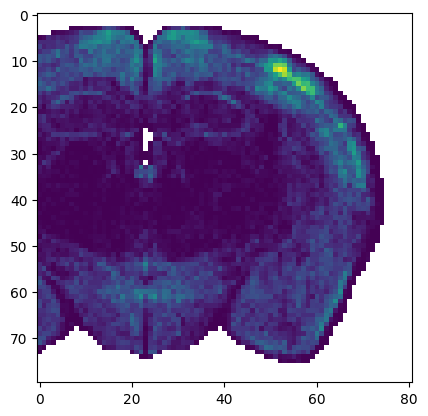

In [14]:
plot_coronal(fos_counts[30], 50, alive_voxels)


## Load the final model fits

In [15]:
final_fos_params = loadmat(os.path.join(FOS_DATA_DIREC, "2023_11_01_params.mat"))
final_fos_params.keys()

dict_keys(['__header__', '__version__', '__globals__', 'factors', 'count_loadings', 'count_row_effects', 'count_col_effects', 'intensity_loadings', 'intensity_row_effects', 'intensity_col_effects', 'intensity_variance'])

In [16]:
# Rename keys as necessary
final_behav_params = loadmat(os.path.join(FOS_DATA_DIREC, "dirichlet_tucker_22_4_4_22.mat"))
final_behav_params['core_tensor'] = final_behav_params['G']
final_behav_params['epoch_factors'] = final_behav_params['E']
final_behav_params['position_factors'] = final_behav_params['P']
final_behav_params['syllable_factors'] = final_behav_params['S']
final_behav_params['loadings'] = final_behav_params['W']

## Download the bootstrap model fits from W&B

This takes about 10 minutes the first time you run it, but then the files are saved on your hard drive.

In [17]:
# download the parameters of the Fos semiNMF fits
api = wandb.Api()
for i in progress_bar(range(0, NUM_BOOTSTRAP)):
    if os.path.exists(os.path.join(FOS_PARAM_DIR, "params_{:04d}.pkl".format(i))):
        # print(f"found results for iteration {i}")
        continue

    artifact = api.artifact(f"{WAND_FOS_BOOTSTRAP_PROJECT}/params_pkl:v{i}")
    artifact.download(root=FOS_PARAM_DIR)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [19]:
# download the parameters of the Fos semiNMF fits
api = wandb.Api()
for i in progress_bar(range(0, NUM_BOOTSTRAP + 3)):
    if os.path.exists(os.path.join(BEHAVIOR_PARAM_DIR, "params_{:04d}.pkl".format(i))):
        # print(f"found results for iteration {i}")
        continue

    try:
        artifact = api.artifact(f"{WAND_BEHAVIOR_BOOTSTRAP_PROJECT}/params_pkl:v{i}")
        # artifact = api.artifact("/params_pkl:v{:d}".format(i))
        artifact.download(root=BEHAVIOR_PARAM_DIR)
    except: 
        print("could not find artifact params_pkl:v{:d}".format(i))
        continue

## Fos -> behavior predictions

In [21]:
def predict_behavior_given_fos(test_fos_counts,
                               train_fos_counts, 
                               fos_params,
                               behav_params):
    """Predict behavioral syllables (across time and space) given 
    test Fos counts.
    """
    if test_fos_counts.ndim == 1:
        is_1d = True
        test_fos_counts = test_fos_counts[None, :]
    else:
        is_1d = False
        assert test_fos_counts.ndim == 2

    fos_mean = train_fos_counts.mean(axis=0)
    fos_var = train_fos_counts.var(axis=0)
    test_fos_centered = test_fos_counts - fos_mean
    
    # Compute the OLS estimate of the fos factors given test fos counts
    fos_loadings = fos_params['count_loadings']            # (mice x n_fos_factors) 
    fos_factors = fos_params['factors'].T                  # (voxels x n_fos_factors)
    fos_loading_cov = np.cov(fos_loadings, rowvar=False)   # (n_fos_factors x n_fos_factors)
    pred_fos_loadings = np.linalg.solve(
        (fos_factors.T / fos_var) @ fos_factors, 
        (fos_factors.T / fos_var) @ test_fos_centered.T).T   # (n_fos_factors, n_pred)
    
    # Train a linear regression to map fos loadings to (unconstrained) behavior loadings
    behav_loadings = behav_params['loadings']          # (mice x n_beh_factors) 
    behav_loadings_unc = tfb.SoftmaxCentered().inverse(behav_loadings)
    lr = LinearRegression()
    lr.fit(fos_loadings, behav_loadings_unc)
    pred_behav_loadings = tfb.SoftmaxCentered()(lr.predict(pred_fos_loadings))

    # Map predicted behavior loadings to predicted syllable counts
    pred_behav = np.einsum('pi,ijkl, mj, kn, lo->pmno', 
                            pred_behav_loadings, 
                            behav_params['core_tensor'], 
                            behav_params['epoch_factors'], 
                            behav_params['position_factors'], 
                            behav_params['syllable_factors'])
    
    return pred_behav[0] if is_1d else pred_behav

### Make test Fos patterns

In [22]:
def make_fos_mask(region, alive_voxels):
    """Make a binary mask for perturbing fos counts
    """
    region_ids = loadmat(os.path.join(FOS_DATA_DIREC, "region_ids_100um.mat"))["regions_small"]
    region_ids = np.transpose(region_ids, (2,1,0))
    region_ids_alive = region_ids[alive_voxels]

    annot = pd.read_csv(os.path.join(FOS_DATA_DIREC, "region_annotations.csv"))
    target_id = annot[annot["name"] == region].id.values[0]
    mask = region_ids_alive == target_id
    return mask

([], [])

<Figure size 640x480 with 0 Axes>

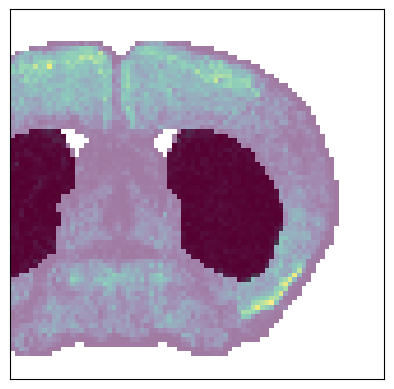

In [23]:
mask  = make_fos_mask("Caudoputamen", alive_voxels)
# mask  = make_fos_mask("Central amygdalar nucleus", alive_voxels)
# mask  = make_fos_mask("Primary motor area", alive_voxels)
# mask  = make_fos_mask("Dentate nucleus", alive_voxels)

plt.figure()
slc = 35
ax, im = plot_coronal(fos_counts[100], slc, alive_voxels)
ax, im = plot_coronal(mask, slc, alive_voxels, ax=ax, alpha=0.5, cmap="Reds")
plt.xticks([])
plt.yticks([])

In [24]:
# Make a pair of test fos maps to predict behavior from
saline_fos_counts = fos_counts[drugs == 10].mean(axis=0)
test_fos_counts = np.row_stack([
    saline_fos_counts,
    saline_fos_counts + 100 * mask
])


### Compute distribution of predicted change in behavior using final model fits

In [25]:
# score_fn = lambda x, x0: np.log(x / x0) # log relative change in probability
score_fn = lambda x, x0: (x - x0)       # absolute change in probability

In [26]:
final_pred_behav = predict_behavior_given_fos(
    test_fos_counts,
    fos_counts, 
    final_fos_params,
    final_behav_params
)
final_pred_behav_change = score_fn(final_pred_behav[1], final_pred_behav[0])

/Users/scott/anaconda3/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:289: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


### Compute distribution of predicted change in behavior across bootstrap replicates

In [27]:
bootstrap_pred_behav_changes = np.zeros((NUM_BOOTSTRAP, NUM_EPOCHS, NUM_POSITIONS, NUM_SYLLABLES))
for i in progress_bar(range(NUM_BOOTSTRAP)):
    fname = "params_{:04d}.pkl".format(i)
    with open(os.path.join(FOS_PARAM_DIR, fname), "rb") as f:
        fos_params = pickle.load(f)

    with open(os.path.join(BEHAVIOR_PARAM_DIR, fname), "rb") as f:
        behav_params = pickle.load(f)

    assert np.all(behav_params['bootstrap_inds'] == fos_params['bootstrap_inds'])

    pred_behav = predict_behavior_given_fos(
        test_fos_counts,
        fos_counts, 
        fos_params,
        behav_params
    )
    bootstrap_pred_behav_changes[i] = score_fn(pred_behav[1], pred_behav[0])
    

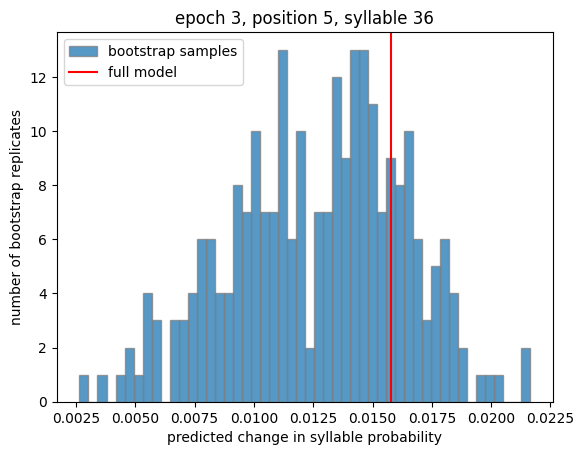

In [34]:
e, p, s = 3, 5, 36
plt.hist(bootstrap_pred_behav_changes[:, e, p, s], 50, alpha=0.75, edgecolor='gray', label='bootstrap samples')
plt.axvline(final_pred_behav_change[e, p, s], color='r', label='full model')
plt.xlabel("predicted change in syllable probability")
plt.ylabel("number of bootstrap replicates")
plt.title(f"epoch {e}, position {p}, syllable {s}")
plt.legend()

### Compute quantile of zero

Text(0, 0.5, 'count')

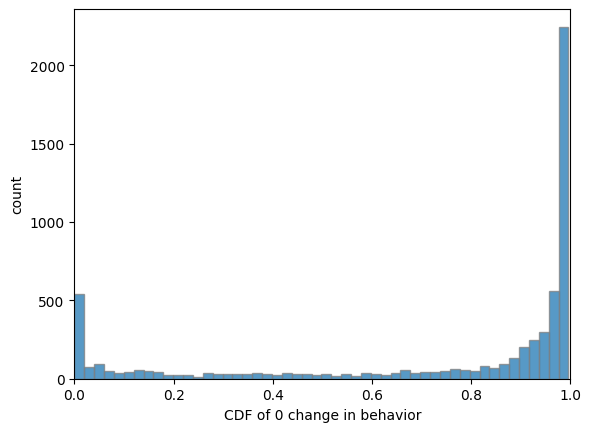

In [29]:
cdf0 = np.sum(bootstrap_pred_behav_changes < 0, axis=0) / (NUM_BOOTSTRAP + 1)

plt.hist(cdf0.ravel(), 50, alpha=0.75, edgecolor='gray', label='bootstrap samples')
plt.xlim(0, 1)
plt.xlabel("CDF of 0 change in behavior")
plt.ylabel("count")

### Compute t statistics

In [48]:
from scipy import stats
sem_pred_behav_change = np.std(bootstrap_pred_behav_changes, axis=0)
tstat_pred_behav_change = final_pred_behav_change / sem_pred_behav_change
pval_pred_behav_change = stats.t.sf(np.abs(tstat_pred_behav_change), NUM_BOOTSTRAP-1)*2

# Make a copy of the changes and nan out the insignificant ones
p_thresh = 0.05 / final_pred_behav_change.size
sig = pval_pred_behav_change < p_thresh
sig_pred_behav_change = final_pred_behav_change.copy()
sig_pred_behav_change[~sig] = np.nan

print(f"num sig. predictions (Bonferroni): {sig.sum()}")

num sig. predictions (Bonferroni): 683


### Show the predicted change and the t statistic

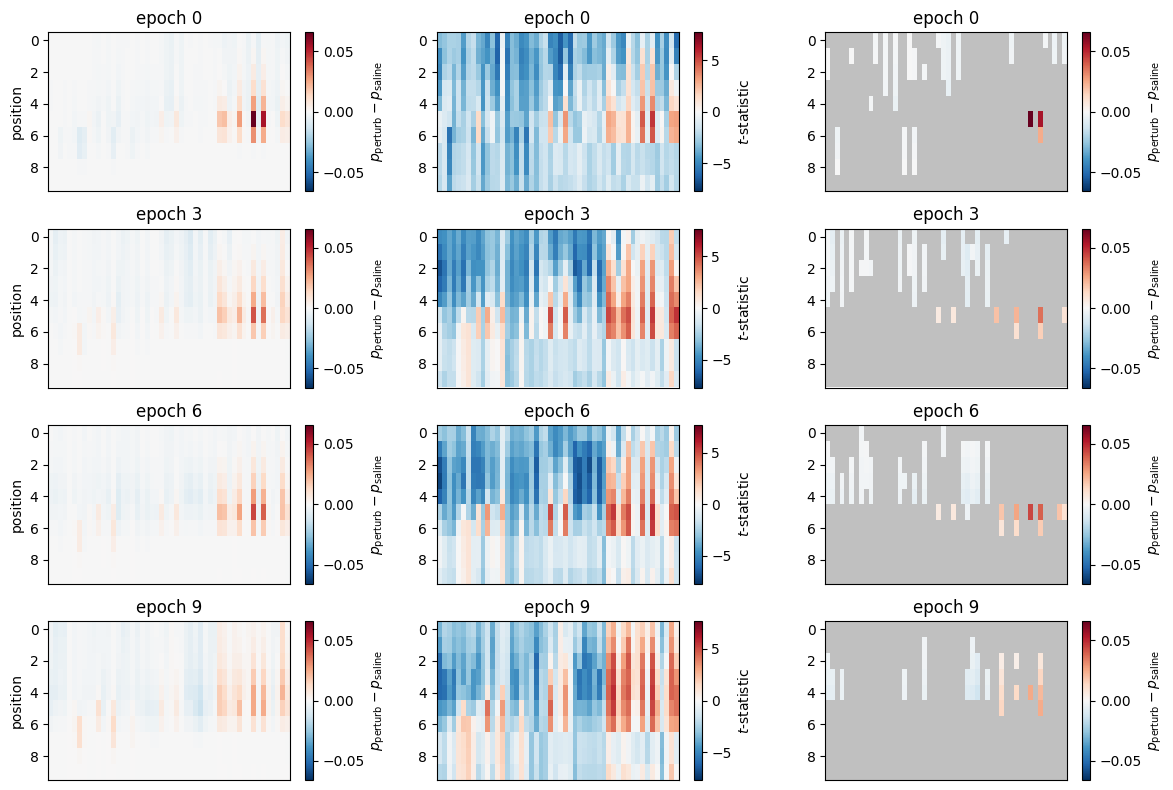

In [49]:
# Plot the changes for a few epochs
epochs_to_plot = [0, 3, 6, 9]
fig, axs = plt.subplots(len(epochs_to_plot), 3, figsize=(12, 2 * len(epochs_to_plot)))
vlim = abs(final_pred_behav_change).max()
tlim = abs(tstat_pred_behav_change).max()
for j, e in enumerate(epochs_to_plot):
    im = axs[j,0].imshow(final_pred_behav_change[e], 
                         cmap=cmap,
                         interpolation="none", 
                         aspect="auto",
                         vmin=-vlim, 
                         vmax=vlim)
    axs[j,0].set_xticks([])
    axs[j,0].set_title(f"epoch {e}")
    axs[j,0].set_ylabel("position")
    # plt.colorbar(im, label=r"$\log \frac{{p_{{\mathsf{{perturb}}}}}}{{p_{{\mathsf{{saline}}}}}}$.")
    plt.colorbar(im, label=r"$p_{{\mathsf{{perturb}}}} - p_{{\mathsf{{saline}}}}$")

    im = axs[j,1].imshow(tstat_pred_behav_change[e], 
                         cmap=cmap,
                         interpolation="none", 
                         aspect="auto",
                         vmin=-tlim, 
                         vmax=tlim)
    axs[j,1].set_xticks([])
    axs[j,1].set_title(f"epoch {e}")
    # axs[j,1].set_ylabel("position")
    # plt.colorbar(im, label=r"$\log \frac{{p_{{\mathsf{{perturb}}}}}}{{p_{{\mathsf{{saline}}}}}}$.")
    plt.colorbar(im, label=r"$t$-statistic")

    im = axs[j,2].imshow(sig_pred_behav_change[e], 
                         cmap=cmap,
                         interpolation="none", 
                         aspect="auto",
                         vmin=-vlim, 
                         vmax=vlim)
    # axs[j,2].set_ylabel("position")
    axs[j,2].set_xticks([])
    axs[j,2].set_title(f"epoch {e}")
    # plt.colorbar(im, label=r"$\log \frac{{p_{{\mathsf{{perturb}}}}}}{{p_{{\mathsf{{saline}}}}}}$.")
    plt.colorbar(im, label=r"$p_{{\mathsf{{perturb}}}} - p_{{\mathsf{{saline}}}}$")

plt.tight_layout()



## Behavior -> Fos predictions

In [50]:
def predict_fos_given_behavior(perturb_behav,
                               fos_params,
                               beh_params,
                               softmax=True,
                               return_loadings=False):
    """Predict behavioral syllables (across time and space) given 
    test Fos counts.
    """
    if perturb_behav.ndim == 3:
        is_1d = True
        perturb_behav = perturb_behav[None, :]
    else:
        is_1d = False
        assert perturb_behav.ndim == 4

    # extract behavior "factors"
    factors = np.einsum('ijkl,nj,kp,ls->inps',
                    beh_params['core_tensor'],
                    beh_params['epoch_factors'],
                    beh_params['position_factors'],
                    beh_params['syllable_factors'])


    # Initialize the 
    saline_loadings = beh_params['loadings'][drugs==10].mean(axis=0)
    test_beh_loadings = np.repeat(saline_loadings[None, :], 
                                  len(perturb_behav), 
                                  axis=0)
    
    # solve for the test behav loadings with a fixed point iteration
    for _ in range(50):
        r = np.einsum('mi,inps->minps', test_beh_loadings, factors)
        C = np.einsum('mi,inps->mnps', test_beh_loadings, factors)
        test_beh_loadings = np.einsum('mnps, minps, mnps -> mi', perturb_behav, r, 1/C)
        test_beh_loadings /= test_beh_loadings.sum(axis=1, keepdims=True)
    
    # Convert loadings to unconstrained form if specified
    unc_test_beh_loadings = tfb.SoftmaxCentered().inverse(test_beh_loadings) \
        if softmax else test_beh_loadings
    unc_beh_loadings = tfb.SoftmaxCentered().inverse(beh_params['loadings']) \
        if softmax else beh_params['loadings']
    
    # train linear regression to map behavior loadings to Fos loadings
    lr = LinearRegression().fit(unc_beh_loadings, fos_params['count_loadings'])
    pred_fos_loadings = lr.predict(unc_test_beh_loadings)
    
    # map predicted Fos loadings to predicted Fos counts
    pred_fos = pred_fos_loadings @ fos_params['factors']    
    pred_fos = pred_fos[0] if is_1d else pred_fos

    return (pred_fos, test_beh_loadings) if return_loadings else pred_fos

### Make test behavior data

In [52]:
# make dummy "data"
saline_behav = np.einsum('i,ijkl,nj,kp,ls->nps', 
                        final_behav_params['loadings'][drugs==10].mean(axis=0), 
                        final_behav_params['core_tensor'],
                        final_behav_params['epoch_factors'],
                        final_behav_params['position_factors'],
                        final_behav_params['syllable_factors'])

# Upweight random syllables
# perturb_behav = saline_behav.copy()
# perturb_behav += 0.001 * np.random.randn(*perturb_behav.shape)
# perturb_behav = np.clip(perturb_behav, 0, np.inf)
# perturb_behav /= perturb_behav.sum()

# More locomotion
perturb_behav = saline_behav.copy()
perturb_behav[:, :, 38:50] *= 10
perturb_behav /= perturb_behav.sum(axis=(1, 2), keepdims=True)

# More grooming
# perturb_behav = saline_behav.copy()
# perturb_behav[:, :, 28:35] *= 10
# perturb_behav /= perturb_behav.sum(axis=(1, 2), keepdims=True)

# More pausing
# perturb_behav = saline_behav.copy()
# perturb_behav[:, :, 19:24] *= 10
# perturb_behav /= perturb_behav.sum(axis=(1, 2), keepdims=True)

# More pausing with lights on
# perturb_behav = saline_behav.copy()
# perturb_behav[6:9, :, 19:24] *= 10
# perturb_behav /= perturb_behav.sum(axis=(1, 2), keepdims=True)

# No pausing
# perturb_behav = saline_behav.copy()
# perturb_behav[:, :, 19:24] *= 0.0
# perturb_behav /= perturb_behav.sum(axis=(1, 2), keepdims=True)

# More rearing (general)
# perturb_behav = saline_behav.copy()
# perturb_behav[:, :, 10:20] *= 10
# perturb_behav /= perturb_behav.sum(axis=(1, 2), keepdims=True)

# More rearing (specific)
# perturb_behav = saline_behav.copy()
# perturb_behav[:, :, np.array([2, 6, 10, 13], dtype=int)] *= 10
# perturb_behav /= perturb_behav.sum(axis=(1, 2), keepdims=True)

# No rearing (specific)
# perturb_behav = saline_behav.copy()
# perturb_behav[:, :, np.array([2, 6, 10, 13], dtype=int)] *= 0.0
# perturb_behav /= perturb_behav.sum(axis=(1, 2), keepdims=True)

test_behav = np.stack([
    saline_behav,
    perturb_behav
])

### Compute predictions with the final model parameters

In [53]:
final_pred_fos, test_loadings = predict_fos_given_behavior(
    test_behav, 
    final_fos_params,
    final_behav_params,
    return_loadings=True
)
final_pred_fos_change = final_pred_fos[1] - final_pred_fos[0]

/var/folders/d1/fsjj9s5n5sdfzt5nrbrkq30m0000gn/T/ipykernel_40926/3296626575.py:11: RuntimeWarning: divide by zero encountered in divide
  final_pred_fos_zscore = final_pred_fos_change / std_fos_counts


### Compute predictions for bootstrap replicates

In [58]:
bootstrap_pred_fos_changes = np.zeros((NUM_BOOTSTRAP, NUM_VOXELS))

for i in progress_bar(range(NUM_BOOTSTRAP)):
    fname = "params_{:04d}.pkl".format(i)
    with open(os.path.join(FOS_PARAM_DIR, fname), "rb") as f:
        fos_params = pickle.load(f)

    with open(os.path.join(BEHAVIOR_PARAM_DIR, fname), "rb") as f:
        behav_params = pickle.load(f)

    assert np.all(behav_params['bootstrap_inds'] == fos_params['bootstrap_inds'])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pred_fos = predict_fos_given_behavior(
            test_behav, 
            fos_params,
            behav_params,
            return_loadings=False
        )
    bootstrap_pred_fos_changes[i] = pred_fos[1] - pred_fos[0]

Look at predicted change in Fos count for a voxel at position (60, 30, 30), which should be in a region of cortex that looks like a strong predicted change.

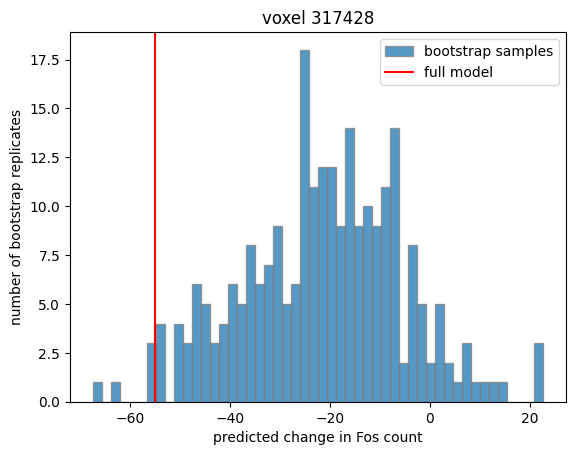

In [60]:
_ii, _jj, _kk = np.where(alive_voxels)
_v = np.where((_ii==60) & (_jj==30) & (_kk==30))[0][0]

plt.hist(bootstrap_pred_fos_changes[:, _v], 50, alpha=0.75, edgecolor='gray', label='bootstrap samples')
plt.axvline(final_pred_fos_change[_v], color='r', label='full model')
plt.xlabel("predicted change in Fos count")
plt.ylabel("number of bootstrap replicates")
plt.title(f"voxel {_v}")
plt.legend()

### Compute t statistics

In [63]:
from scipy import stats
sem_pred_fos_change = np.std(bootstrap_pred_fos_changes, axis=0)
tstat_pred_fos_change = final_pred_fos_change / sem_pred_fos_change
pval_pred_fos_change = stats.t.sf(np.abs(tstat_pred_fos_change), NUM_BOOTSTRAP-1)*2

# Make a copy of the changes and nan out the insignificant ones
p_thresh = 0.05 / final_pred_fos_change.size
sig = pval_pred_fos_change < p_thresh
sig_pred_fos_change = final_pred_fos_change.copy()
sig_pred_fos_change[~sig] = np.nan

print(f"num sig. predictions (Bonferroni): {sig.sum()}")

num sig. predictions (Bonferroni): 0


### Compute quantile of zero

Text(0, 0.5, 'count')

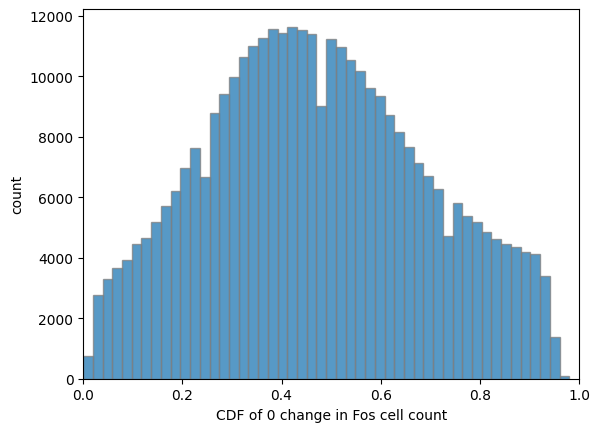

In [61]:
cdf0 = np.sum(bootstrap_pred_fos_changes < 0, axis=0) / (NUM_BOOTSTRAP + 1)

plt.hist(cdf0.ravel(), 50, alpha=0.75, edgecolor='gray', label='bootstrap samples')
plt.xlim(0, 1)
plt.xlabel("CDF of 0 change in Fos cell count")
plt.ylabel("count")

### Show the final predictions and t-statistics

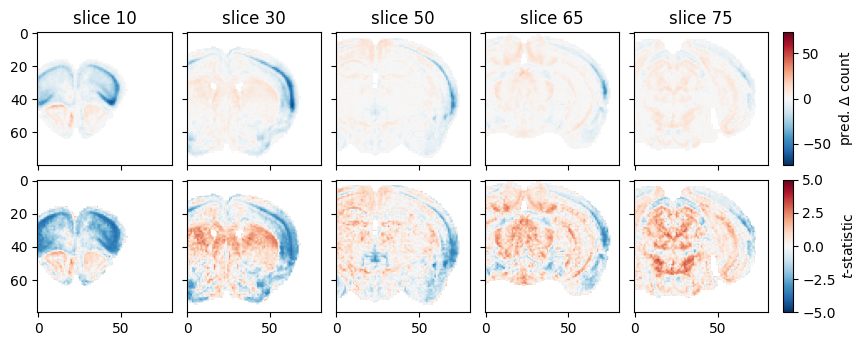

In [84]:
# Plot the changes for a single slice of the brain
slices_to_plot = [10, 30, 50, 65, 75]

# First plot the final predictions
fig = plt.figure(figsize=(3 * len(slices_to_plot), 8))
grid = ImageGrid(fig, 211,
                 nrows_ncols=(2, len(slices_to_plot)),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="edge",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

vlim = abs(final_pred_fos_change).max()
for j, slc in enumerate(slices_to_plot):
    # Plot the final prediction
    ax, im1 = plot_coronal(final_pred_fos_change, 
                           slc, 
                           alive_voxels,
                           ax=grid[j],
                           alpha=1,
                           cmap="RdBu_r", 
                           vmin=-vlim, vmax=vlim)
    ax.set_title(f"slice {slc}")
    
    # Plot the t-statistic
    _, im2 = plot_coronal(tstat_pred_fos_change, 
                          slc, 
                          alive_voxels,
                          ax=grid[len(slices_to_plot) + j],
                          alpha=1,
                          cmap="RdBu_r", 
                          vmin=-5, vmax=5)
    
    # Finally, plot the predicted change over the SEM (z score again? ugh terrible naming)
    # _, im3 = plot_coronal(pval_pred_fos_change, 
    #                       slc, 
    #                       alive_voxels,
    #                       ax=grid[2 * len(slices_to_plot) + j],
    #                       alpha=1,
    #                       cmap="Greys_r", 
    #                       vmin=0, vmax=1)
    ax.set_title(f"slice {slc}")

cbar1 = grid[len(slices_to_plot) - 1].cax.colorbar(im1, label=r'pred. $\Delta$ count')
cbar2 = grid[2 * len(slices_to_plot) - 1].cax.colorbar(im2, label=r'$t$-statistic')
# cbar3 = grid[- 1].cax.colorbar(im3, label=r'$p$-value')

### Control FDR with BH

1. Sort p-values
2. find largest $k$ such that $P_{(k)} < k/m \alpha$ 

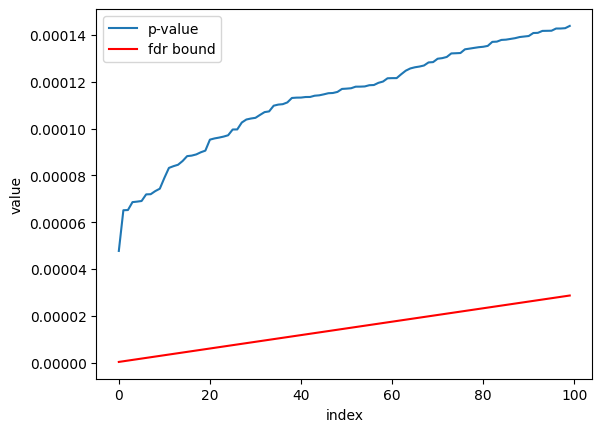

In [83]:
fdr_level = 0.10
sorted_pvals = np.sort(pval_pred_fos_change)
upper_bound = (1 + np.arange(NUM_VOXELS)) / NUM_VOXELS * fdr_level

plt.plot(sorted_pvals[:100], label='p-value')
plt.plot(upper_bound[:100], '-r', label='fdr bound')
plt.xlabel("index")
plt.ylabel("value")
plt.legend()
# plt.xlim(0, 100)

Unfortunately, it looks like the predictions still don't rise to the level of significance, even when we try to control FDR (with BH) rather than FWER (with Bonferroni correction).

## Next Steps

- Cross-validated prediction accuracy
- Leave one out predictions
